## This notebook contains code to illustrate how Prophet works on a sample account

** We start with the input csv file and filter for a single account **

In [1]:
# import all the required libraries and read the input file
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import warnings
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')
# read the input csv file
nycha = pd.read_csv("../output/nycha/NYCHA_TS.csv", parse_dates=['Month'])
nycha = nycha.fillna(0)
nycha = nycha[nycha['Value'] != 0]
nycha = nycha.drop('Unnamed: 0', axis=1)
nycha = nycha.groupby('Account').filter(lambda x: len(x) > 50)

In [2]:
# group all the data on Building_Meter and select the top 5 rows
nycha.groupby('Account').size().head(5)

Account
1.0 - BLD 01_7836716    90
1.0 - BLD 01_7838586    87
1.0 - BLD 02_7694040    90
1.0 - BLD 03_7177432    89
1.0 - BLD 04_7381828    90
dtype: int64

In [3]:
# lets select a random account from this list and filter the data frame.
nycha_f = nycha[nycha['Account'] == '15.0 - BLD 01_7890006']
nycha_f = nycha_f.drop('Account', axis = 1)
# rename the columns as per the requirements of Prophet
nycha_f = nycha_f.rename(columns={'Month':'ds', 'Value':'y'})
nycha_f = nycha_f.reset_index()
nycha_f = nycha_f.drop('index', axis = 1)
# create a copy of the original dataframe
df = nycha_f.copy()

In [4]:
# run the prophet model with yearly seasonality, interval width or confidence interval is set to 95% to 
# increase the sampling threshold, mcmc sample size of 50 performs full Bayesian sampling to include uncertainty
# in seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.95, mcmc_samples=50)
# fit the model using this dataset
model.fit(df)
# get predicted values from the model for the entire dataset
predicted = model.predict()

** In the section below, we look at the trend and seasonality components from the model, which along with the residuals, are added up to generate the forecast ** 

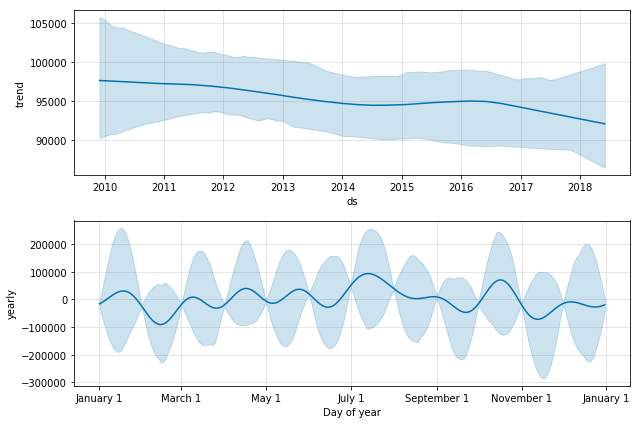

In [5]:
model.plot_components(predicted);
# since the data that we have is monthly, the seasonality component is yearly in the plot below.
# the trend component indicates an overall decreasing trend for this particular account in the electricity consumption values over the years.

** Here we look at the plot of all the forecasted values and compare with the originals **

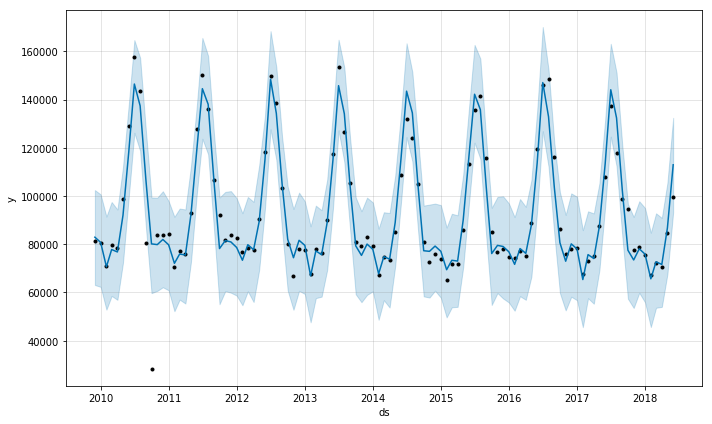

In [6]:
model.plot(predicted);

** If we analyze the plot above, the shaded blue area is the uncertainty interval generated by Prophet using Monte Carlo simulations, the solid blue line is the forecasted value generated by the model that we fit above, and the black dots are the original values for this account. ** <br>
**It is relatively easy to determine outliers by looking at black dots that do not lie in this uncertainty interval and flagging them. ** <br>
**Also, there are a couple of parameters that can be tuned for tweaking the uncertainty interval which are highlighted below **
- ** Using the 'interval_width' parameter which by default is 80%, but we have increased it to 95%, while initializing Prophet above. In general increasing this parameter will widen the uncertainty interval and reducing it will narrow it down. **
- ** Using the 'mcmc_samples' parameter, which stands for Markov Chains Monte Carlo, Prophet will also take into consideration the uncertainty in seasonality. By default, Prophet only considers the uncertainty in the trend component. Including this parameter results in a slightly longer duration for execution, since full Bayesian sampling is performed. **  


** In the section below, we will analyze the results in a table format, or a dataframe **

In [7]:
actvpred = predicted[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
actvpred['y_orig'] = nycha_f['y']
actvpred.head(10)

,ds,yhat,yhat_lower,yhat_upper,y_orig
0,2009-12-01,82932.866413,63105.791963,102471.728396,81163.636364
1,2010-01-01,80782.757186,62325.600543,100678.123726,80654.545455
2,2010-02-01,70668.956904,52864.361788,91465.040714,71117.241379
3,2010-03-01,77810.485449,58575.299757,97510.266042,79811.790879
4,2010-04-01,76812.898717,56959.689179,94398.206756,78442.396313
5,2010-05-01,92042.016026,72382.878544,112016.082902,98921.904762
6,2010-06-01,118331.356777,99695.224040,137959.228158,128880.000000
7,2010-07-01,146449.565199,126239.449748,164674.362589,157820.215054
8,2010-08-01,137412.046011,118764.645267,157331.769264,143446.451613
9,2010-09-01,106638.593376,87108.419918,127035.522644,80360.000000


- ** 'ds' is the month **
- ** 'yhat' is the forecasted value for electricity consumption **
- ** 'yhat_lower' is the lower boundary of our uncertainty interval **
- ** 'yhat_upper' is the upper boundary of our uncertainty interval **
- ** 'y_orig' is the original value for electricity consumption **
    

** It is fairly straightforward to flag outliers from this table. We could create a new column that would check for each 'y_orig', if it lies between 'yhat_lower' and 'yhat_upper'. **

In [8]:
actvpred['Anomaly'] = np.where((actvpred['y_orig'] >= actvpred['yhat_lower']) & (actvpred['y_orig'] <= actvpred['yhat_upper']), 'No', 'Yes')
actvpred.head(10)

,ds,yhat,yhat_lower,yhat_upper,y_orig,Anomaly
0,2009-12-01,82932.866413,63105.791963,102471.728396,81163.636364,No
1,2010-01-01,80782.757186,62325.600543,100678.123726,80654.545455,No
2,2010-02-01,70668.956904,52864.361788,91465.040714,71117.241379,No
3,2010-03-01,77810.485449,58575.299757,97510.266042,79811.790879,No
4,2010-04-01,76812.898717,56959.689179,94398.206756,78442.396313,No
5,2010-05-01,92042.016026,72382.878544,112016.082902,98921.904762,No
6,2010-06-01,118331.356777,99695.224040,137959.228158,128880.000000,No
7,2010-07-01,146449.565199,126239.449748,164674.362589,157820.215054,No
8,2010-08-01,137412.046011,118764.645267,157331.769264,143446.451613,No
9,2010-09-01,106638.593376,87108.419918,127035.522644,80360.000000,Yes
